# A Data mining approach to predict human wine taste preferences
A [dataset](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) with white and red <i>vinho verde</i> samples is considered.

The <b>Feature vector:</b>
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual suggar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

<b>Final Prediction:</b>
12. Quality

The original [paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) uses MR(multiple regression), SVN (Support Vector Machines) and NN (Neural Networks) for data mining.

<b>In this project on the other hand we will utilize Random Forests for classification.</b>

# Game Plan
The ML Pipeline:

1. Question and the required data
2. Acquire the data
3. Data Analysis
4. Prepare the data for the ML model
5. Train the Model
6. Test the Model
7. Evaluate the Model
8. Interpret the Model and report results visually and numerically
9. Adjusting the Model



In [1]:
import pandas as pd
import numpy as np
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import pydot
# Visualizing decision trees
from IPython.display import Image

sns.set()

# Data Analysis: Cleaning & Preparing

Data analysis usually occupies 80% of the time of any Data Scientist and Machine Learning Engineer. Without this crucial phase all the state-of-the-art models offered by *sklearn* would be completely in vain.

1. Tidy Data
2. Missing Data
3. Outliers
4. Class Imbalance Problem
5. Feature Correlation

In [2]:
features = pd.read_csv("data/winequality-white.csv")
features.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...


## Tidy Data

As can be clearly noticed this dataset is messy in its own way! Therefore the first step would be to [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) the data.

In [3]:
# Get the columns
features_list = features.columns[0].split(";")
features_list = [feature.lstrip('"').rstrip('"') for feature in features_list]

# Get the values
values = np.array(features[features.columns])
new_values = []
for row in values:
    new_values.append(list(map(float, row[0].split(";"))))
new_values = np.array(new_values)

# Form the new dataframe
features = pd.DataFrame(data=new_values, columns=features_list)
features.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3827,5.1,0.23,0.18,1.0,0.053,13.0,99.0,0.98956,3.22,0.39,11.5,5.0
1559,8.8,0.35,0.49,1.0,0.036,14.0,56.0,0.99200,2.96,0.33,10.5,4.0
2993,6.8,0.18,0.28,9.8,0.039,29.0,113.0,0.99406,3.11,0.45,10.9,7.0


After these little tweaks we can tell that:
1. Each feature forms a column
2. Each observation/sample forms a row

## Identifying anomalies/missing data

- **Missing Data:** Imputing or dropping values
- **Outliers:** Can be dropped

In [4]:
print("We have {} records and {} features".format(*features.shape))

We have 4898 records and 12 features


One way to spot different annomalies as well as missing data is to compute a summary statistics

In [5]:
features.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


The dataset contains no missing values. However, it looks like we might have some outliers. Let's visualize the data in order to be able to better differentiate it.

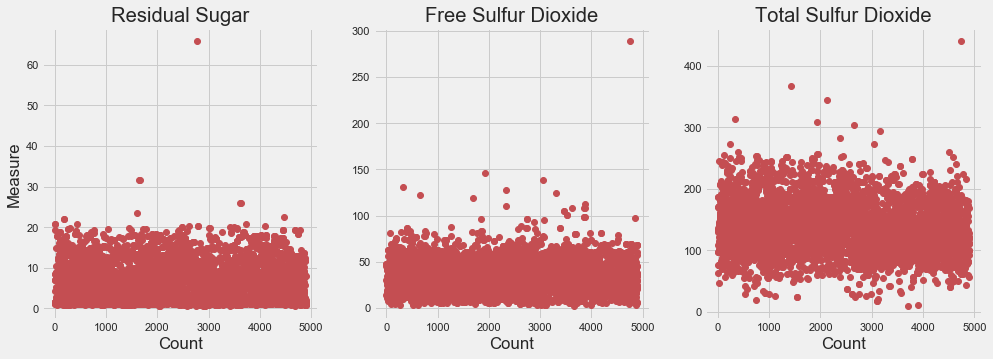

In [6]:
# Set the style
plt.style.use('fivethirtyeight')

# Plotting layout
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# residual sugar
ax1.plot(features['residual sugar'], 'ro')
ax1.set_ylabel("Measure"); ax1.set_xlabel("Count")
ax1.set_title("Residual Sugar")

# free sulfur dioxide
ax2.plot(features['free sulfur dioxide'], 'ro')
ax2.set_ylabel(""); ax2.set_xlabel("Count")
ax2.set_title("Free Sulfur Dioxide")

# total sulfur dioxide
ax3.plot(features['total sulfur dioxide'], 'ro')
ax3.set_ylabel(""); ax3.set_xlabel("Count")
ax3.set_title("Total Sulfur Dioxide")
plt.show()

We can certainly see outliers for these attributes. One way to deal with outliers is to remove and if we don't have many we can do so.

The outlier in the first figure belongs to <i>quality 6.0</i> for which we do have plenty of samples. However, the two other outliers belong to <i>3.0</i> for which we do not have too many samples. Dropping them means dropping 10% of the data for that kind of quality.

Lets set a threshold of <i>125</i> for outliers in <i>Free Sulfur Dioxide</i> and <i>300</i> for outliers in <i>Total Sulfur Dioxide</i> in order to further investigate this.

In [7]:
features[features['total sulfur dioxide']>300]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
325,7.5,0.27,0.31,5.80,0.057,131.0,313.0,0.99460,3.18,0.59,10.5,5.0
1417,8.6,0.55,0.35,15.55,0.057,35.5,366.5,1.00010,3.04,0.63,11.0,3.0
1931,7.1,0.49,0.22,2.00,0.047,146.5,307.5,0.99240,3.24,0.37,11.0,3.0
2127,9.1,0.33,0.38,1.70,0.062,50.5,344.0,0.99580,3.10,0.70,9.5,5.0
2654,6.9,0.40,0.22,5.95,0.081,76.0,303.0,0.99705,3.40,0.57,9.4,5.0
4745,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3.0


In [8]:
features[features['free sulfur dioxide']>125]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
325,7.5,0.270,0.31,5.8,0.057,131.0,313.0,0.99460,3.18,0.59,10.5,5.0
1931,7.1,0.490,0.22,2.0,0.047,146.5,307.5,0.99240,3.24,0.37,11.0,3.0
2334,7.5,0.230,0.35,17.8,0.058,128.0,212.0,1.00241,3.44,0.43,8.9,5.0
3050,6.2,0.255,0.24,1.7,0.039,138.5,272.0,0.99452,3.53,0.53,9.6,4.0
4745,6.1,0.260,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3.0


We can see that it seems that <i>quality=3</i> seems to have more outliers in both of these attributes and since we don't have much data of it (20 samples) in total it does not make sense to drop the outliers for these two features. 

So we will stick with dropping a single outlier for the feature <i>Residual Sugar<i>.

In [9]:
features = features.drop(index=features[features['residual sugar']>40].index, axis=0)

## Class-Imbalance Problem
Class Imbalance problem is a really nasty issue which is often difficult to tackle. Therefore a thumb up rule here is: data, data and some more data. When we have made sure that the phenomenon is derived from nature itself (from the way things are) and not from low amount of data we can proceed with investigating it.

In [10]:
print("Classes are indeed imbalanced")
print(round(100*(features['quality'].value_counts()/features.shape[0])), 2)

Classes are indeed imbalanced
6.0    45.0
5.0    30.0
7.0    18.0
8.0     4.0
4.0     3.0
3.0     0.0
9.0     0.0
Name: quality, dtype: float64 2


We can see that a whooping **75%** of the data belong to only two classes!

However, if our classes are separated nicely then the class-imbalance is not really a problem. Although there are tools and techniques to check this here we will just visualize for a couple of attributes and classes at a time.

In [11]:
def get_rand_class():
    """Get 3 random classes from a total of 6.
    """
    rand = []
    while True:
        if len(rand) == 3:
            return rand
        r = random.randint(0,6)
        if r not in rand:
            rand.append(r)

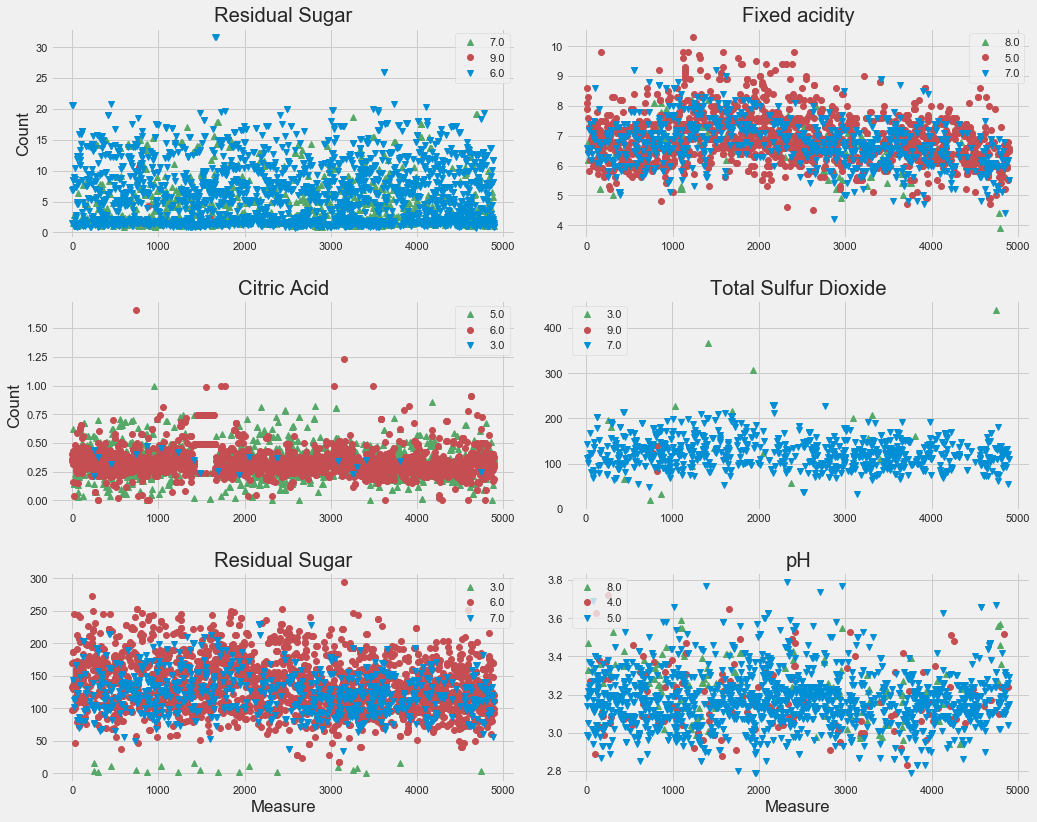

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(15,12))


# Feature: residual sugar
rs = list(features['residual sugar'].groupby(features['quality']))

# Randomly pick 3 classes to display
c1, c2, c3 = get_rand_class()
ax1.plot(rs[c1][1], 'g^', label=rs[c1][0])
ax1.plot(rs[c2][1], 'ro', label=rs[c2][0])
ax1.plot(rs[c3][1], 'v', label=rs[c3][0])
ax1.set_xlabel(""); ax1.set_ylabel("Count"); ax1.set_title("Residual Sugar")
ax1.legend()

# Feature: Fixed acidity
fa = list(features['fixed acidity'].groupby(features['quality']))

# Randomly pick 3 classes to display
c1, c2, c3 = get_rand_class()
ax2.plot(fa[c1][1], 'g^', label=fa[c1][0])
ax2.plot(fa[c2][1], 'ro', label=fa[c2][0])
ax2.plot(fa[c3][1], 'v', label=fa[c3][0])
ax2.set_xlabel(""); ax2.set_ylabel(""); ax2.set_title("Fixed acidity")
ax2.legend()

# Feature: citric axid
ca = list(features['citric acid'].groupby(features['quality']))
c1, c2, c3 = get_rand_class()
ax3.plot(ca[c1][1], 'g^', label=ca[c1][0])
ax3.plot(ca[c2][1], 'ro', label=ca[c2][0])
ax3.plot(ca[c3][1], 'v', label=ca[c3][0])
ax3.set_xlabel(""); ax3.set_ylabel("Count"); ax3.set_title("Citric Acid")
ax3.legend()

# Feature: total sulfur dioxide
tsd = list(features['total sulfur dioxide'].groupby(features['quality']))
c1, c2, c3 = get_rand_class()
ax4.plot(tsd[c1][1], 'g^', label=tsd[c1][0])
ax4.plot(tsd[c2][1], 'ro', label=tsd[c2][0])
ax4.plot(tsd[c3][1], 'v', label=tsd[c3][0])
ax4.set_xlabel(""); ax4.set_ylabel(""); ax4.set_title("Total Sulfur Dioxide")
ax4.legend()

# Feature: residual sugar
rs2 = list(features['residual sugar'].groupby(features['quality']))
c1, c2, c3 = get_rand_class()
ax5.plot(rs2[c1][1], 'g^', label=rs2[c1][0])
ax5.plot(tsd[c2][1], 'ro', label=rs2[c2][0])
ax5.plot(tsd[c3][1], 'v', label=rs2[c3][0])
ax5.set_xlabel("Measure"); ax5.set_ylabel("Count"); ax5.set_title("Residual Sugar")
ax5.legend()

# Feature: pH
ph = list(features['pH'].groupby(features['quality']))
c1, c2, c3 = get_rand_class()
ax6.plot(ph[c1][1], 'g^', label=ph[c1][0])
ax6.plot(ph[c2][1], 'ro', label=ph[c2][0])
ax6.plot(ph[c3][1], 'v', label=ph[c3][0])
ax6.set_xlabel("Measure"); ax5.set_ylabel(""); ax6.set_title("pH")
ax6.legend()


plt.tight_layout(pad=2)

We can tell from this plots that the features are not separated at all (some exceptions are there but they do not change the rule). These means that the class-imbalance problem for this dataset is real!

Among the options that we are left with is *undersampling* or *oversampling* but for now we will just stick with the data as is and see how our model fares.

## Feature correlation
A high correlation between features is almost always not feasible for the ML algorithms. Therefore we always aim to feature engineer correlated features.

### Correlation with the quality variable
Lets see important variables in predicting the quality by checking the feature's correlation with it.

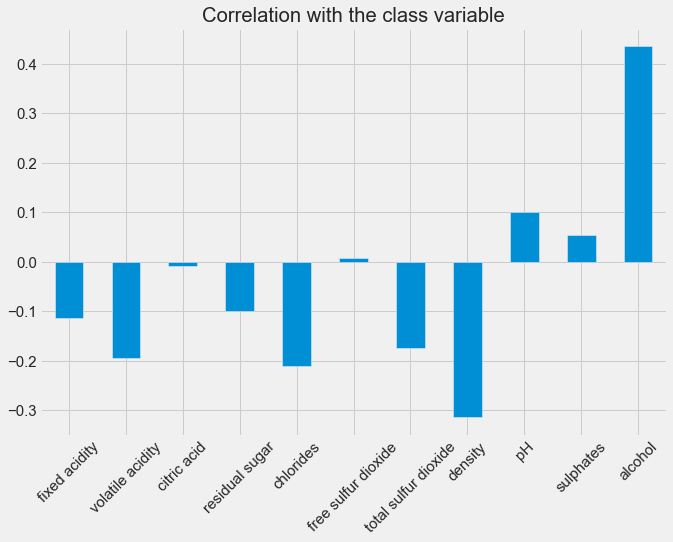

In [13]:
# Drop the quality and plot with pandas
features.drop("quality", axis=1).corrwith(features['quality']).plot.bar(figsize=(10,7),
                                        title='Correlation with the class variable', rot=45, fontsize=15)
plt.show()

So, taking the correlation into acount we can see that *alcohol* is the most important feature in our feature vector for predicting the quality of the wine. Note that even variables that are negatively correlated with it (like *density*) are indeed important because they could be contributors of a lower quality. *Citric acid* and *free sulfur dioxide* seem to have the lowest correlation.

### Correlation Matrix: Correlation of features with each-other.

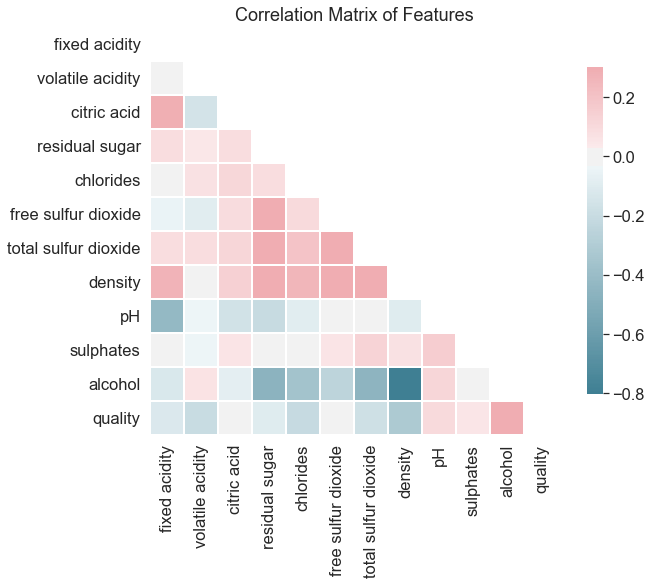

In [14]:
sns.set(style='white', font_scale=1.5)

# Compute the correlation matrix
# The correlation matrix is an array where the main diagonal separetes two identical triangles
corrMatrix = features.corr()

# Create a mask for the upper triangle so that we can ignore it later when building the heatmap
# When we pass this mask to the heatmap function it will generate no data for the upper triangle
mask = np.zeros_like(corrMatrix, dtype=np.bool)
# Get the indices of the upper-triangle of arr: triu_indices_from
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
# Colormap for the different values of the correlation matrix
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(9, 7))
plt.title("Correlation Matrix of Features")

# Draw the heatmap
sns.heatmap(corrMatrix, square=True, mask=mask, cmap=cmap, vmax=.3, center=0, linewidths=1.0,
          cbar_kws={"shrink": 0.8})

plt.show()

The features seem to be somewhat correlated with each-other. *alcohol* and *density* are negatively correlated to a rather significant amount. These two particular features are also highly correlated with the *quality*. An increase of alcohol increases the quality but an increase in density decreases it. Therefore it doesn't seem such a good idea to merge them in one single feature.

# Prepare the data for the machine learning model

1. One-Hot Encoding
2. Class and Features
3. Train/Test

### One-Hot encoding: We need not perform this for our current dataset

## Features and classes
The algorithm does not require the inputs to be numpy arrays but in general it is a good idea to be solid on both pandas and numpy and other ML algorithms might require so. Moreover, numpy is usually used at preprocessing steps such as imputing and scaling. So we'll convert the features columns and class column into numpy arrays.

In [15]:
# The predicted classes
labels = np.array(features['quality'])

# Features
features_list = list(features.columns)
features_list.remove('quality')

# Features values
features_values = features.drop('quality', axis = 1)
features_values.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1


## Train & Test Data

In [16]:
# Split the data into train & test
train_features, test_features, train_labels, test_labels = train_test_split(features_values, labels, 
                                                                              test_size = 0.25, random_state = 3)

print("Shape of our train and test samples")
print("Shape of train features:", train_features.shape)
print("Shape of train labels:", train_labels.shape)
print("Shape of test features:", test_features.shape)
print("Shape of test labels:", test_labels.shape)

Shape of our train and test samples
Shape of train features: (3672, 11)
Shape of train labels: (3672,)
Shape of test features: (1225, 11)
Shape of test labels: (1225,)


# Train the Model

In [17]:
# Instantiate Model
rf = RandomForestClassifier(n_estimators=100, random_state=3)

# Train the model
rf.fit(train_features, train_labels);

# Make Predictions on Test Data
One way to do this is using the confusion matrix and then calculating the Micro-Precision

$ MicroP = \frac{TP}{(TP+FP)} $

In [18]:
predictions = rf.predict(test_features)
confusion_mat = confusion_matrix(test_labels, predictions)
microP = sum(np.diag(confusion_mat) / sum(sum(confusion_mat)))

print("Micro precision:", round(microP*100, 2))

Micro precision: 67.35


# Evaluate the Model

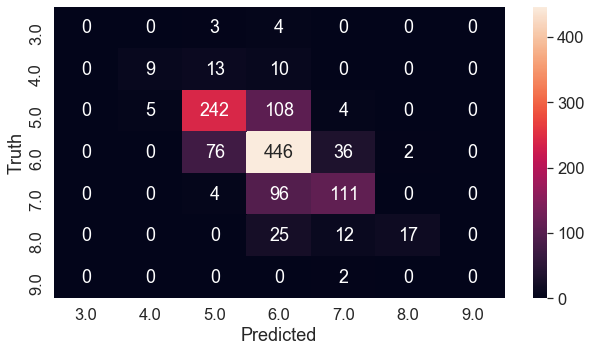

In [19]:
# Visualize confusion matrix
plt.figure(figsize=(9,5))
xticklabels=np.append(3.0, np.unique(predictions))
xticklabels=np.append(xticklabels, 9.0)
yticklabels=np.unique(np.array(test_labels))

sns.heatmap(confusion_mat, square=False, annot=True, fmt='d', cbar=True, xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

In [20]:
print("Number of samples per class, real data",collections.Counter(np.array(test_labels)))
print("Number of samples per class, predicted data",collections.Counter(predictions))

Number of samples per class, real data Counter({6.0: 560, 5.0: 359, 7.0: 211, 8.0: 54, 4.0: 32, 3.0: 7, 9.0: 2})
Number of samples per class, predicted data Counter({6.0: 689, 5.0: 338, 7.0: 165, 8.0: 19, 4.0: 14})


It looks like our model is not doing such a good job since its accuracy is <b>67.3%</b>.

It completely misses out on classes with quality <i>9</i> and <i>3</i> and misclassifies a lot of other classes. As already investigated a little bit, this might be due to the class-imbalance problem.

**However**, the paper reports that, when admitting only the correct classifed classes, the overal accuracy was <b>62.4%</b>. So already our model is faring better than the SVN and NN version's of the paper. The performance is then substantionally increased when they set a tolerance of accepting responses that are correct within the one of the two nearest classes, obtaining an accuracy of <b>89.0%.</b>

Let us calculate this kind of tolerance accuracy as described by the paper and observe the results of our model.

In [21]:
sumTp = 0
sumTpFp = sum(sum(confusion_mat))

for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat)):
        
        # element in main diagonal
        if (i == j):
            sumTp += confusion_mat[i][j]
        
        # element around main diagonal
        elif (j == i+1) & (i<5):
            sumTp += confusion_mat[i][j]
            
        elif (j == i-1) & (i>0):
            sumTp += confusion_mat[i][j]
            
microP_tol = sumTp/sumTpFp
print("Tolerance Precision:", round(microP_tol*100, 2))

Tolerance Precision: 95.59


So, if we set a tolerance of accepting responses that are correct within the one of the two nearest classes, we obtain an accuracy of <b>95.59%</b> which is pretty good and even better than the original paper's results (although the paper is from 2009)!

# Interpreting Model Results

## Visualizing a Single Decision Tree

In [22]:
# Pull out one random tree from the forest
tree = rf.estimators_[int(random.random()*10)]

# Export the image to a dot file
export_graphviz(tree, out_file='images/tree.dot', feature_names=features_list, rounded=True, precision=2)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('images/tree.dot')

# Write graph to a png file
graph.write_png('images/tree.png')

In [23]:
print("The depth of the tree is", tree.tree_.max_depth)

The depth of the tree is 25


### Visualizing a smaller decision Tree

In [24]:
mini_rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=3)
mini_rf.fit(train_features, train_labels)
predictions2 = mini_rf.predict(test_features)

confusion_mat2 = confusion_matrix(test_labels, predictions2)
print("Micro average precision:", round(sum(np.diag(confusion_mat2))/sum(sum(confusion_mat2)), 2))

Micro average precision: 0.52


Understandibly the precision is decreasing. Let's visualize the tree so that we can better understand what's going on (incidentally decision trees have the advantage of being readily interpretable).

In [25]:
mini_tree = mini_rf.estimators_[1]
export_graphviz(mini_tree, out_file='images/mini_tree.dot', feature_names=features_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('images/mini_tree.dot')
graph.write_png('images/mini_tree.png')

Visualize the tree

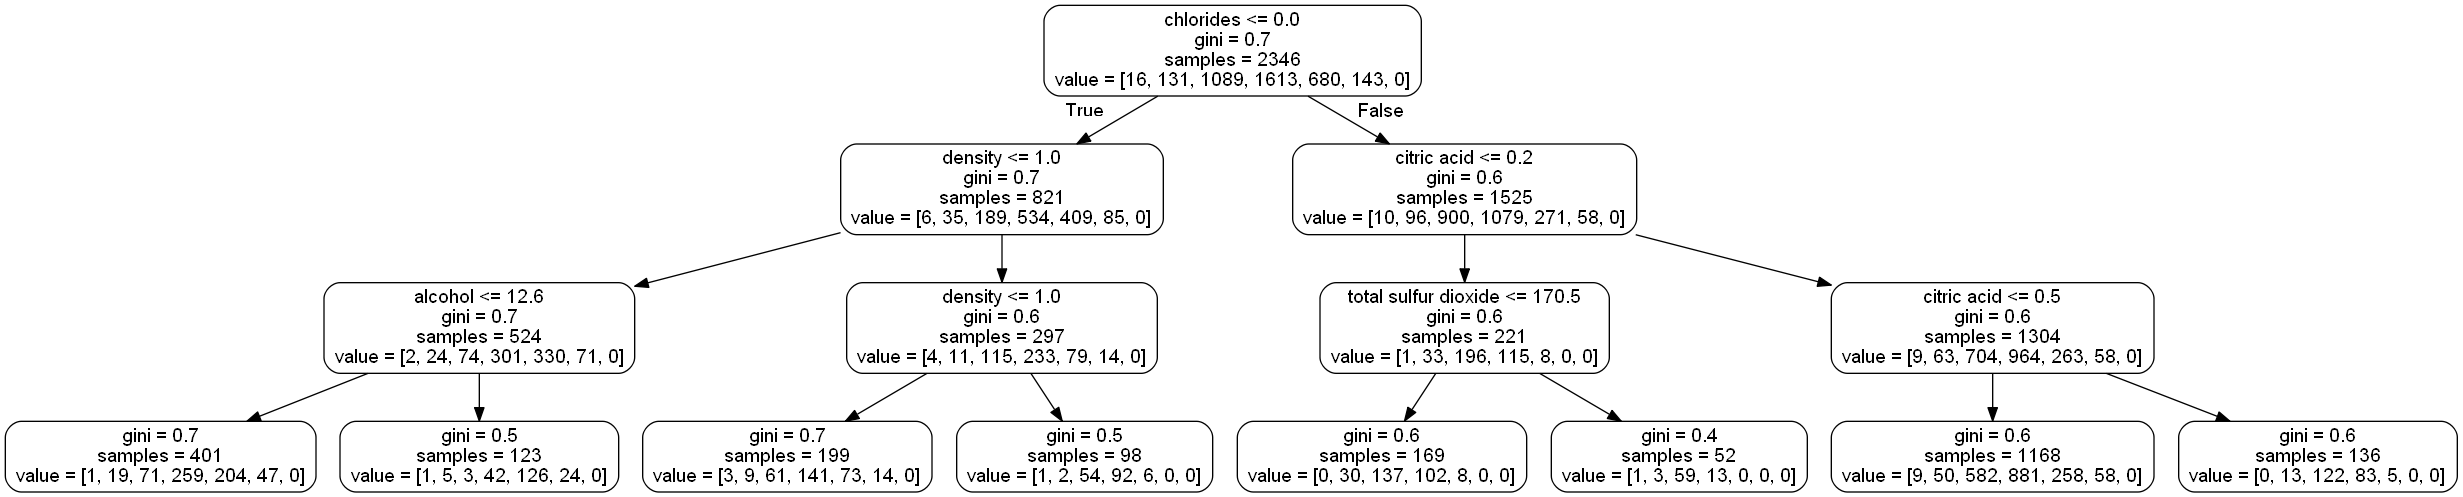

In [26]:
Image(graph.create_png()) 

Decision Trees is one of the ML algorithms that can be readily interpretated by humans. So suppose that we have a sample such that *chlorides<=0*, *density<=1*, *alcohol<=12.6* then we would end up at the first leaf on the left.

Here we can see that the leaf is far from pure with a high [gini](https://en.wikipedia.org/wiki/Gini_coefficient) of 0.7. We see that we have 401 samples and the classified class will be class 6 because it has the largest number of samples, namely 259 (at the *value* array, calsses start from 3 and end to 9).

### On Random Forests

If we see the number of samples in the head node it is <i>2346</i> which is significantly lower than the total number of training samples <i>(3672)</i>. This is because Random Forests incorporate two kind of random processes:
1. Pick a random number of samples
2. Pick a random number of features from the feature vector

This ensures the uniqueness of its trees. This method is called <i>bootstrap agreggating</i> or short <i>bagging</i>.

## Variable Importances

Lets investigate the importance of each variable. We already tried to do such a thing earlier with correlation but this is the real deal! It is not at an uncommon occurrence that too many variables might spoil the model. Who knows, maybe we could even further boost our model.

In [27]:
importances = list(rf.feature_importances_)
imp_variables = [(feat, imp) for feat, imp in zip(features_list, importances)]

# Sort
imp_variables.sort(key=lambda x: x[1], reverse=True)
imp_variables

[('alcohol', 0.11568384075552725),
 ('volatile acidity', 0.10185649535933751),
 ('density', 0.10110051357596392),
 ('free sulfur dioxide', 0.09330242740295164),
 ('residual sugar', 0.09047985878936818),
 ('total sulfur dioxide', 0.08952500650824227),
 ('pH', 0.08546560401441144),
 ('chlorides', 0.0845628893222712),
 ('citric acid', 0.0825965114269682),
 ('sulphates', 0.08034064196487345),
 ('fixed acidity', 0.07508621088008484)]

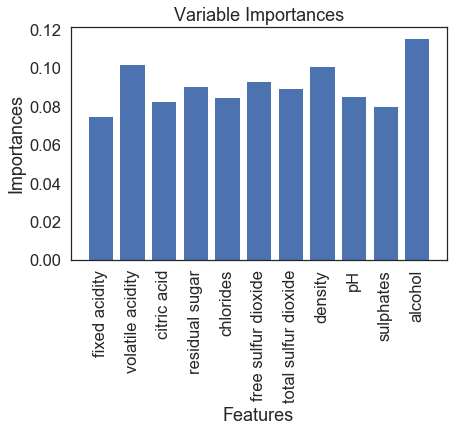

In [28]:
# Visualize variable importances
plt.bar(features_list, importances)
plt.xticks(rotation='vertical')
plt.xlabel("Features"); plt.ylabel("Importances"); plt.title("Variable Importances"); plt.show()

The result is quite different from the SVN output as reported in the paper.

For the white wine the top 5 variable importances are:
1. Sulphates: 20%
2. Alcohol: 14%
3. Residual Sugar: 13%
4. Citric acid: 11%
5. Total Sulfur dioxide 10.5%

In our model the results are quite different with only two results being in the top five for both models. 

This tells us that for predicting the quality of a white wine <i>alcohol</i> is the most important feature, follower by <i>volatile acidity</i> and <i>density</i> which all have more than 10% of the importance. Maybe this is a sign of why our model is doing better. After all the paper is from 2009 and it is quite likely that the state-of-the-art implementation of scikit-learn is more robust than the algorithm used by the paper.

**To conclude, all our variables seem to be important and only minor differences exist between them.**


# Conclusion

The model that we build can classify with 95.59% the quality of the wine (with a tolerance of 1 point in both directions). This is much better than the 89% accuracy of the paper (from 2009).

Next we will take a look at possible ways to adjust and improve the model.